# Reference solution for Upptec case - Regression

This is one way to work through the Upptec case, where we do the data analysis and data wrangling in several steps to arrive at a feature set that is used in the machine learning part.

### TODO
* More documentation
* Add more machine learning algorithms
* More data wrangling

----

## Explanation of Imports
__time__ - Used to put a slight delay between each iteration when plotting in a for loop

__datetime__ - Module to handle the date column

__pandas__ - Flexible data structure and data analysis library. Will be used to load the data and most of the preprocessing is done with this.

__numpy__ - Module for scientific computing on the data

__matplotlib__ - Plotting library. Used for handling plotting figures, but not actually used to plot anything.

__seaborn__ - Plotting library with more functions and nicer design that __matplotlib__

__stats__ - Statistics toolbox from Scipy

__StandardScaler__ - Preprocessing class to scale data to have 0 mean and 1 (unit) variance.

__model_selection__ - train_test_split is used for splitting the data into training and testings sets before we actually start training a model

__linear_model__ - Module that contains many of "simpler" models that we are going to use for machine learning

In [2]:
import time

import datetime

# pandas
import pandas as pd
from pandas import Series,DataFrame

import math

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
from scipy import stats
%matplotlib inline

# preprocessing
from sklearn.preprocessing import StandardScaler

# machine learning
from sklearn.model_selection import train_test_split
from sklearn import linear_model

## Data preprocessing/wrangling
In this part we will work through the data set to choose the features that will be used to train our machine learning model. We can't use all the features for several reasons and the ones that we will use may not be in the shape and type that can be used for machine learning algorithms. Some of the things that we need to keep in mind when doing the preprocessing are

* There may be missing values that we have to handle in some way, as most machine learning algorithms can't handle it.
* Not all features have a "clear" relationship with the price in our data set. Depending on the algorithm used, having too many "irrelevant" features may just confuse the algorithm to learn the wrong things.
* We often want to have numerical features to have a normal distribution, as this property is often required for optimal efficiancy when using machine learning algorithms

In [3]:
tv_ori_df = pd.read_csv('/data/feature_prices_tv.csv')
tv_ori_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5987 entries, 0 to 5986
Data columns (total 81 columns):
date                              5987 non-null object
price                             4330 non-null float64
producer                          5987 non-null object
Bildstorlek                       5987 non-null int64
Bildförhållande                   5986 non-null object
50Hz / 100Hz                      0 non-null float64
Zoom                              111 non-null object
Bildsystem                        0 non-null float64
Multinorm / Euro                  0 non-null float64
Ljudtyp                           959 non-null object
Ljudeffekt, MPO                   0 non-null float64
Ljudeffekt, RMS                   1282 non-null object
Subwoofer                         114 non-null object
Inbyggd centerhögtalare           114 non-null object
Dolby ProLogic                    14 non-null object
Automatisk kanalinställning       0 non-null float64
Insomningstimer              

There are a total 5987 entries/rows in the data set, but there are several columns that have more or less null values, i.e. missing data. In some of the cases where there are few missing values, we could maybe try to fill them in. But this may not be reasonable in this case as each row corresponds to a real item. So the first step will be to remove the columns where there are too many missing values. We have arbitrarily chosen the threshold to be atleast 5000 non-null values. We obviously need to have the price too even though it only has 4330 non null values.

In [4]:
def filter_columns(df, threshold):
    new_df = pd.DataFrame()
    for col in df:
        if df[col].count() > threshold:
            new_df[col] = df[col]
    return new_df

filtered_tv_df = filter_columns(tv_ori_df, 5500)
filtered_tv_df['price'] = tv_ori_df['price']
filtered_tv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5987 entries, 0 to 5986
Data columns (total 29 columns):
date                              5987 non-null object
producer                          5987 non-null object
Bildstorlek                       5987 non-null int64
Bildförhållande                   5986 non-null object
Scart                             5946 non-null float64
VGA in                            5937 non-null object
Bildskärmsteknik                  5983 non-null object
Digital utgång                    5916 non-null object
Upplösning                        5987 non-null object
Upplösningsformat                 5987 non-null object
HDMI in                           5978 non-null object
Komponent in                      5920 non-null object
Minneskortsläsare                 5921 non-null object
Timeshift                         5968 non-null object
3D-stöd                           5986 non-null object
DLNA.1                            5986 non-null object
USB          

### Closer look at the price
All right, now we have a starting set of features that are not too "empty". Before tackling the issue of which features to choose, we want to make sure that the target values, the price, is in a good shape and as close to a normal distribution as we can get it.

Skew: 3.5177504655
Kurtosis: 26.7696465293


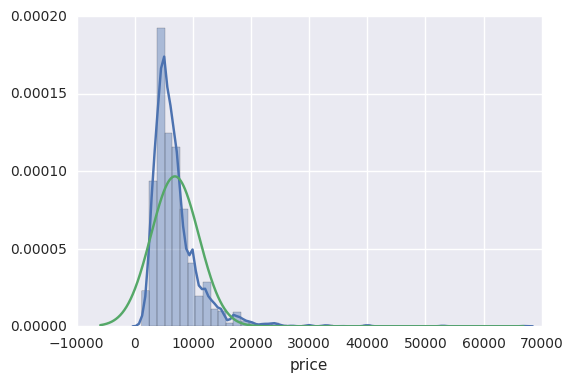

In [5]:
dropped_df = filtered_tv_df.dropna().copy()
sns.distplot(dropped_df['price'])
print("Skew: " + str(dropped_df['price'].skew()))
print("Kurtosis: " + str(dropped_df['price'].kurt()))

temp = dropped_df['price']

mu = temp.mean()
sigma = math.sqrt(temp.var())
min_x = temp.min()
max_x = temp.max()
norm_x = np.linspace(-min_x * 5, max_x, 1000)
plt.plot(norm_x,mlab.normpdf(norm_x, mu, sigma))

The green line shows the shape of normal distribution fitted using the mean and variance of the price, and the blue line is actual distribution of the price.

Extremely high kurtosis (optimal at 0), which means that the distribution has a pointier peak than a normal distribution.

The skew is not as bad (optimal also at 0), but still a bit off from a normal distribution.

A common way of fixing this is to use a log transform.

Skew: 0.356497396296
Kurtosis: 0.711570610427


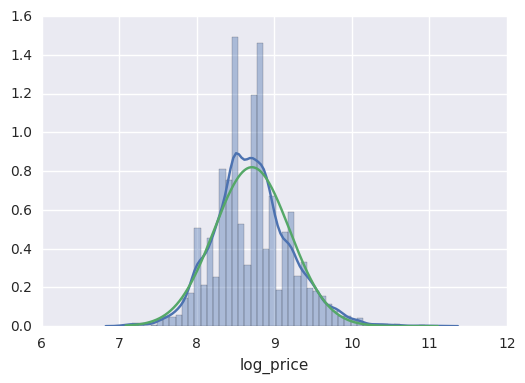

In [6]:

dropped_df['log_price'] = dropped_df['price'].map(lambda p: math.log(p))
# boxcox_df = DataFrame(boxcox_price[0], columns=['box_price'])
sns.distplot(dropped_df['log_price'])
print("Skew: " + str(dropped_df['log_price'].skew()))
print("Kurtosis: " + str(dropped_df['log_price'].kurt()))

temp = dropped_df['log_price']

mu = temp.mean()
sigma = math.sqrt(temp.var())
min_x = temp.min()
max_x = temp.max()
norm_x = np.linspace(min_x, max_x, 1000)
plt.plot(norm_x,mlab.normpdf(norm_x, mu, sigma))

Seems to have somewhat fixed the problem if we only look that the numbers and the shape of the line, but the histogram (the stacks behind the lines) looks a bit iffy and not really like a normal distribution, which may be because of the blue line is just a smoothed version of the histogram.

### Handling the date
As the date can't really be seen as a categorical feature, which means that we have to transform it into a numerical value. A common way to do this is to convert it to a unix timestamp. This will give us too big values compared to all the other features. Therefore we use the StandardScaler to rescale the values.

In [7]:
# Transform date into number
dropped_df['date'].head()

def transform_date(dt):
    new_date = datetime.datetime.strptime(dt, '%Y-%m-%d')
    unix_start_time = datetime.datetime.utcfromtimestamp(0)
    return (new_date - unix_start_time).total_seconds() * 1000

dropped_df['date_time'] = dropped_df['date'].map(lambda dt: transform_date(dt))

date_scaler = StandardScaler()
dropped_df['date_time'] = date_scaler.fit_transform(dropped_df['date_time'].values.reshape(-1, 1))

### Let's look at the data (bivariate style)

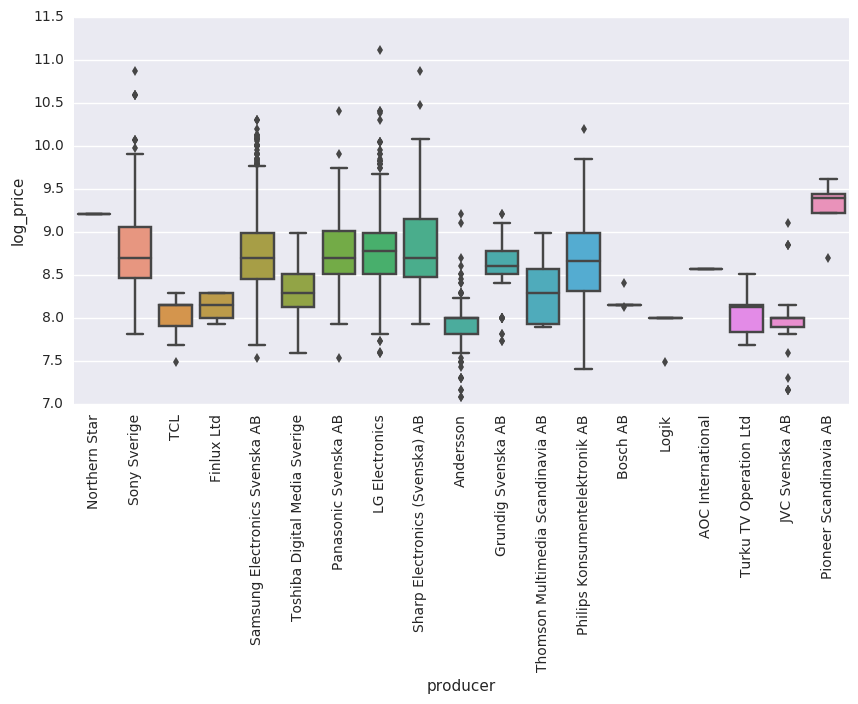

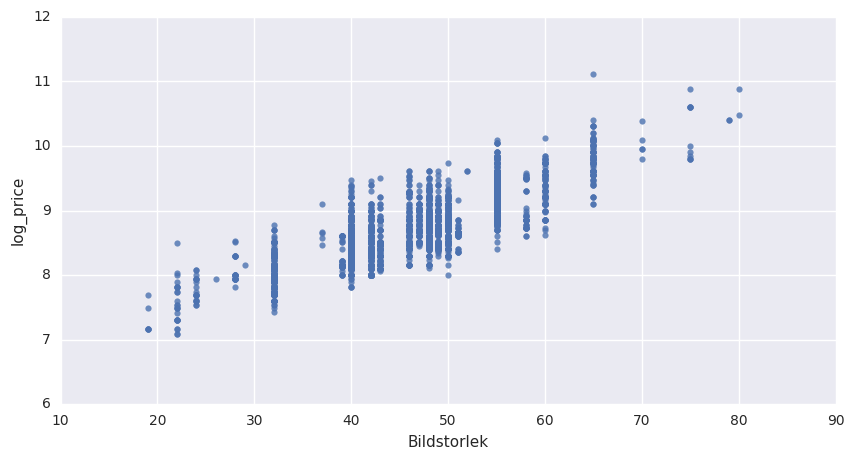

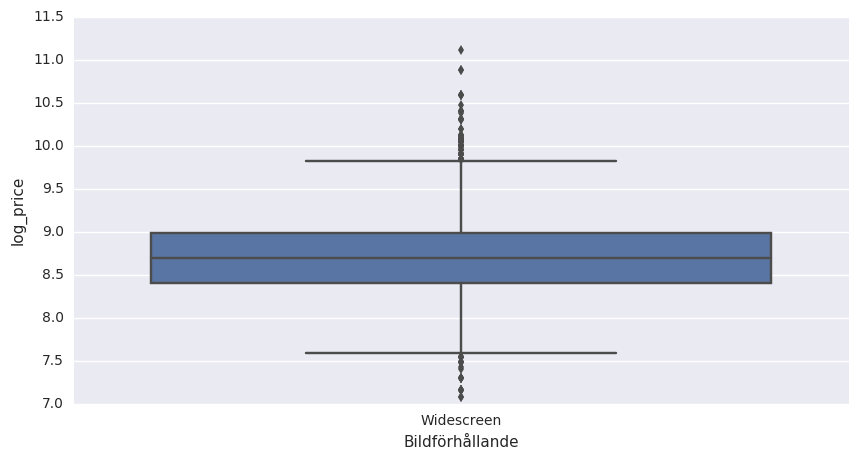

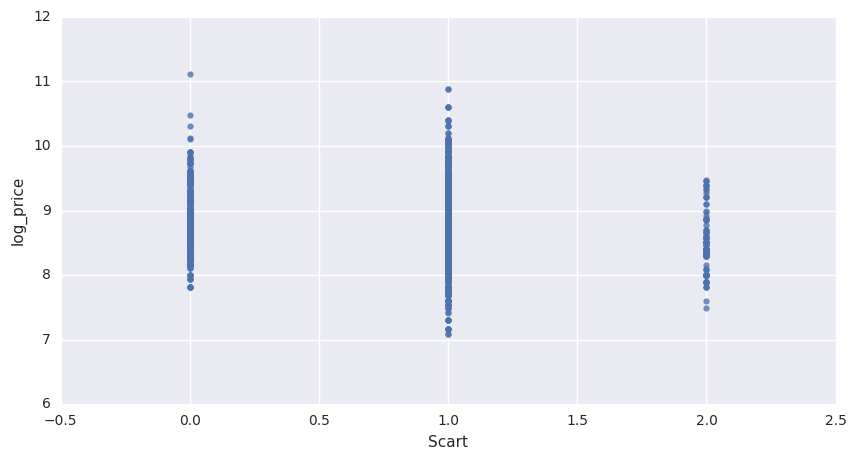

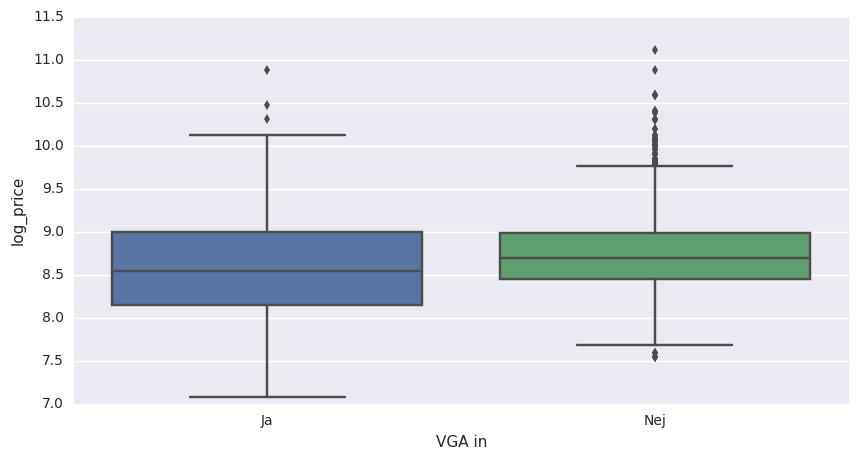

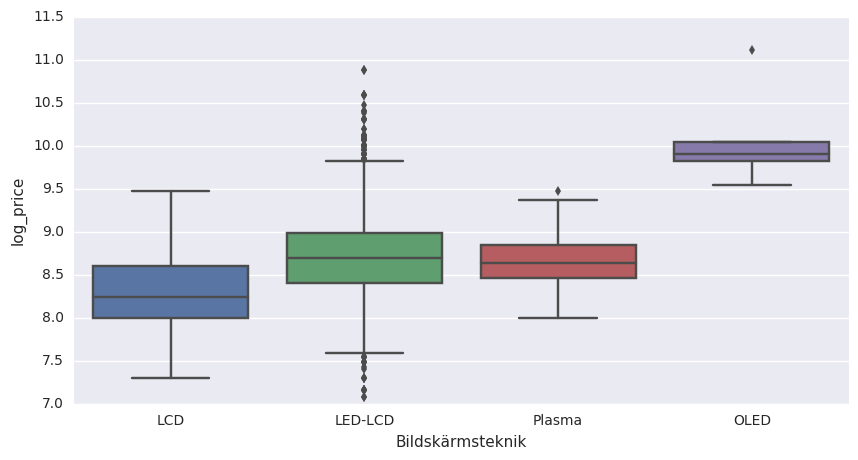

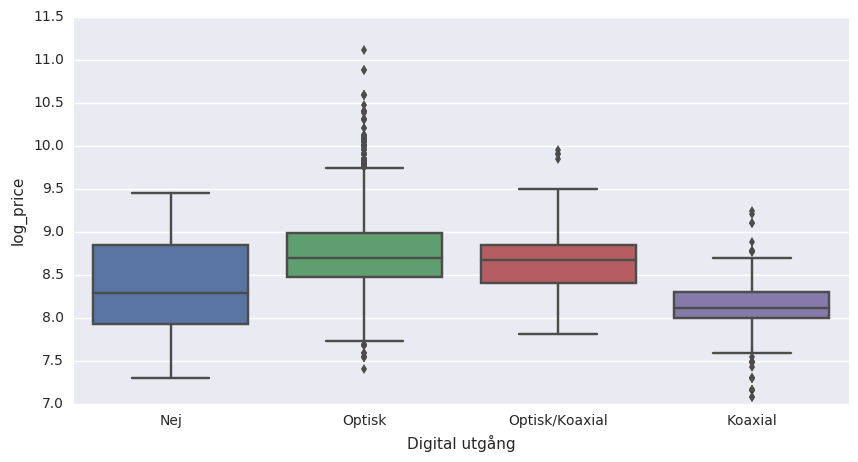

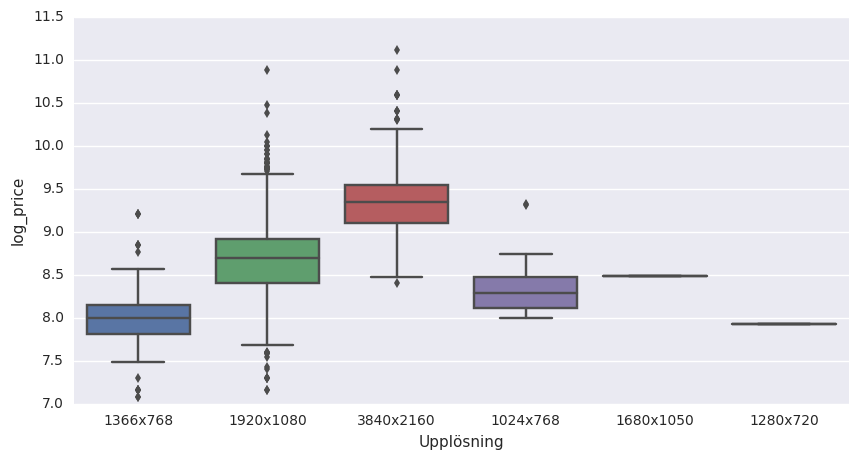

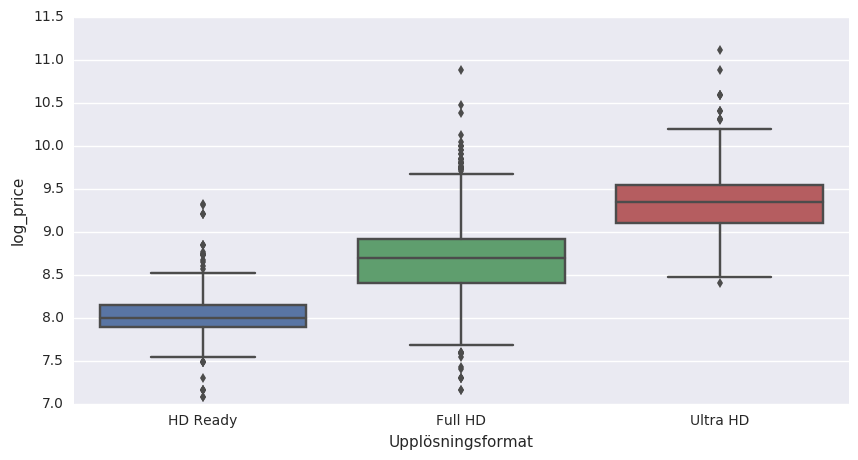

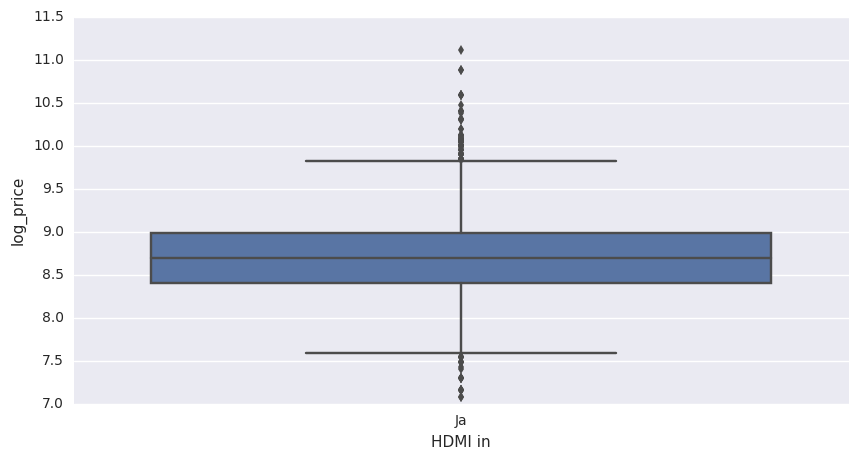

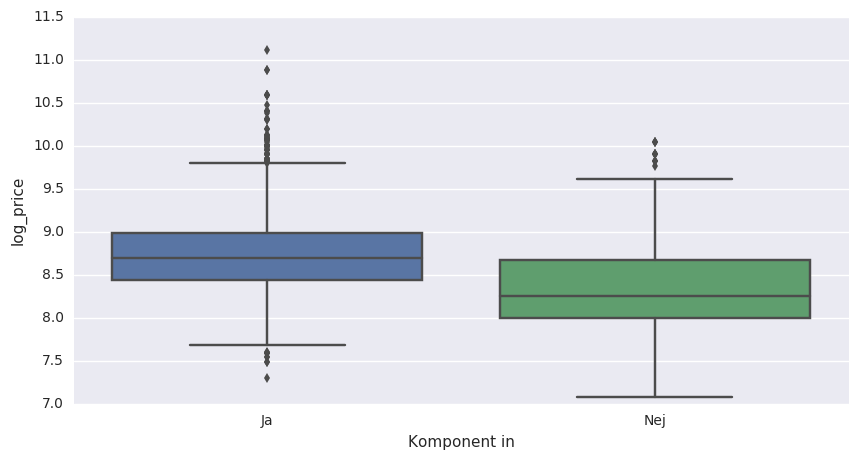

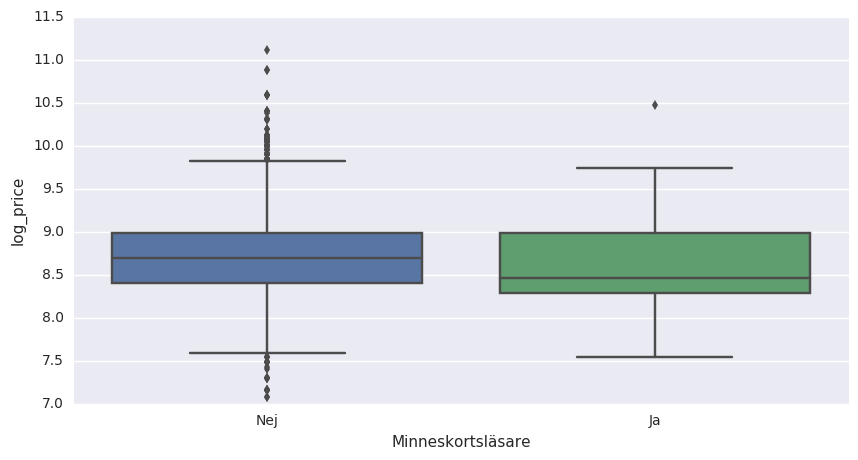

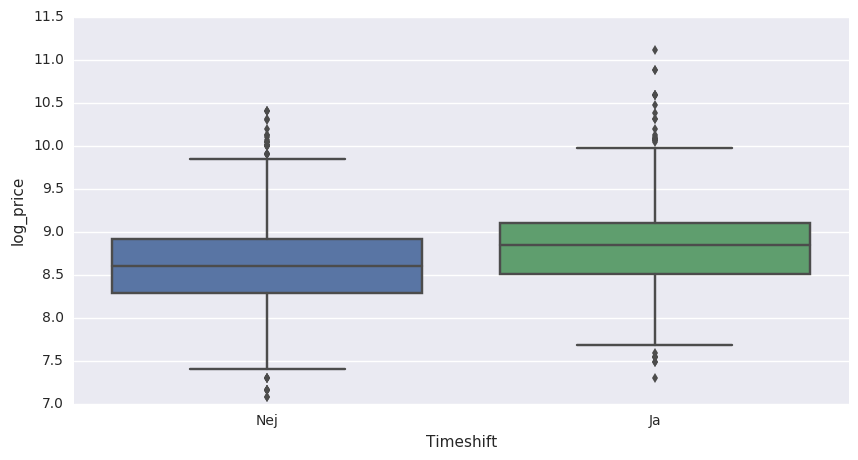

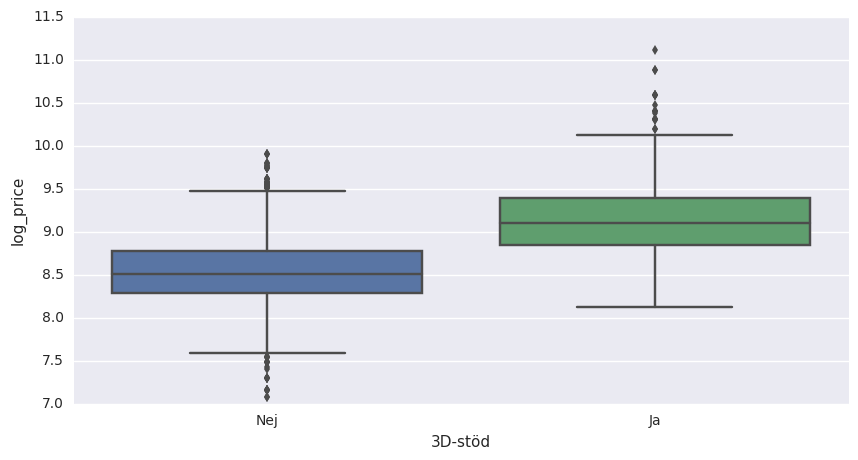

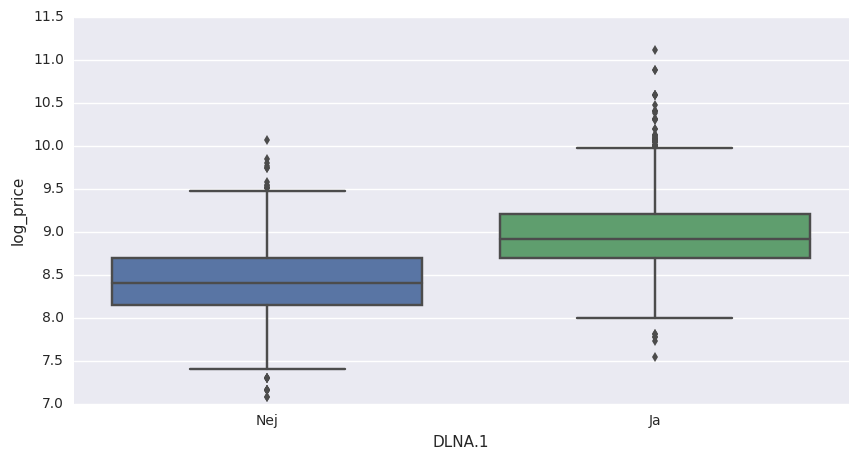

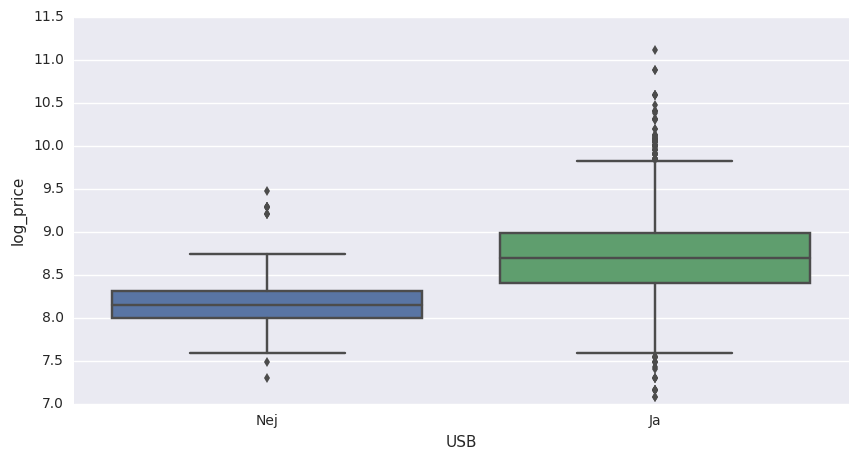

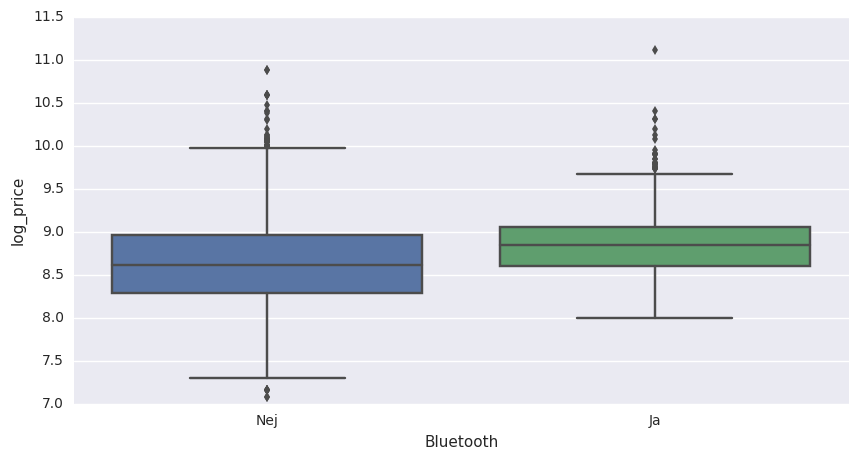

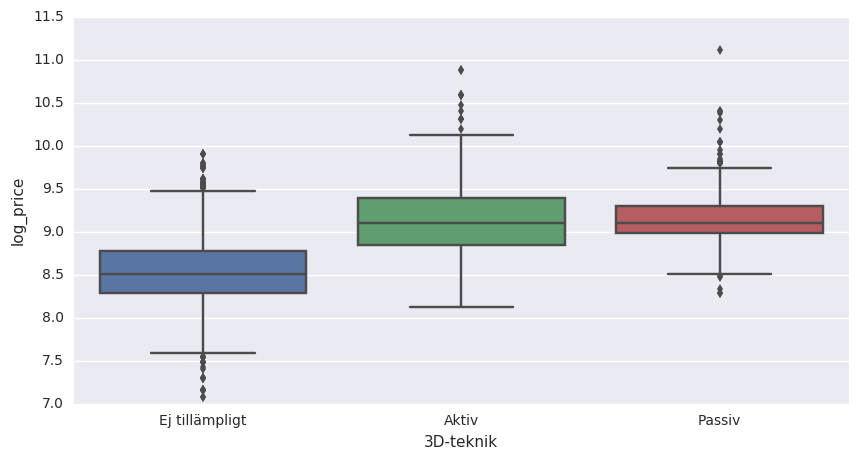

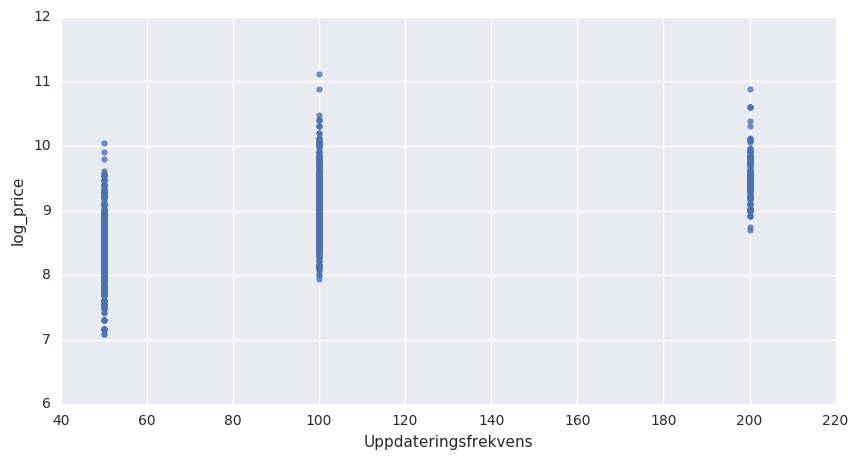

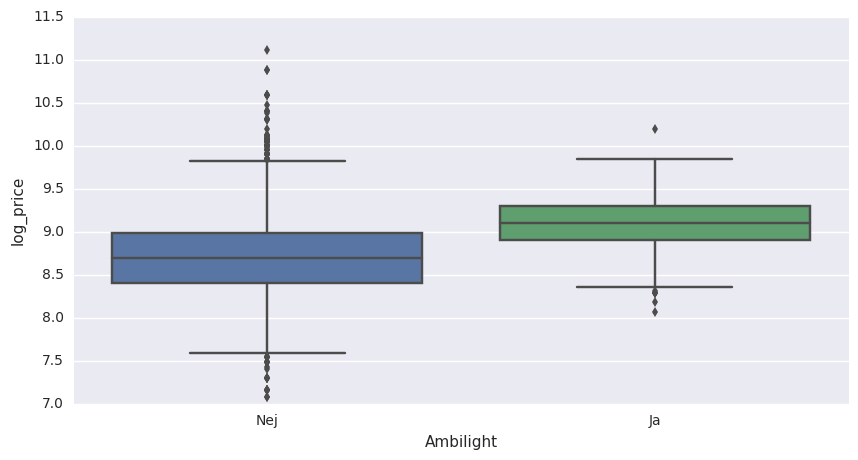

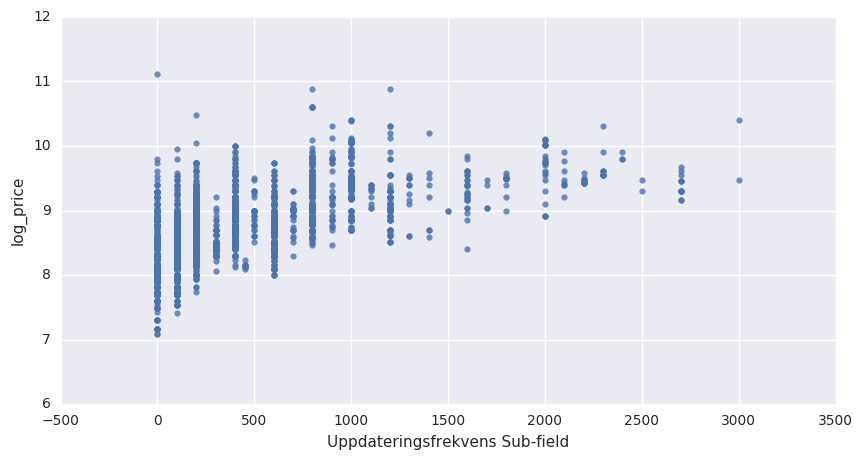

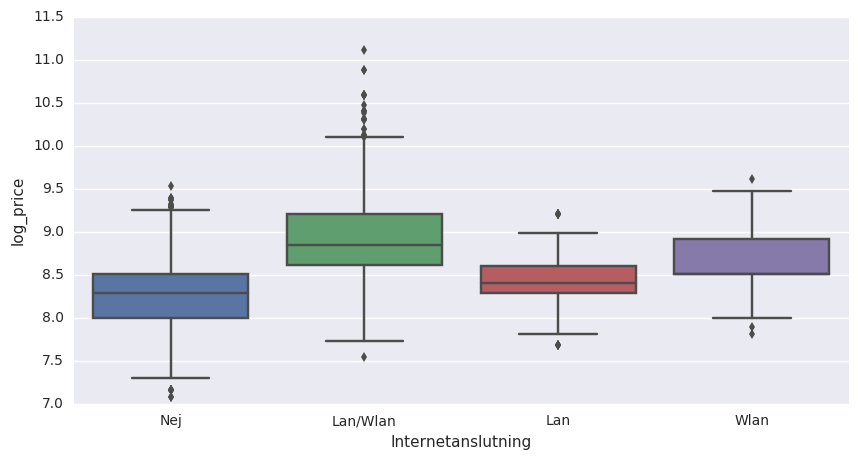

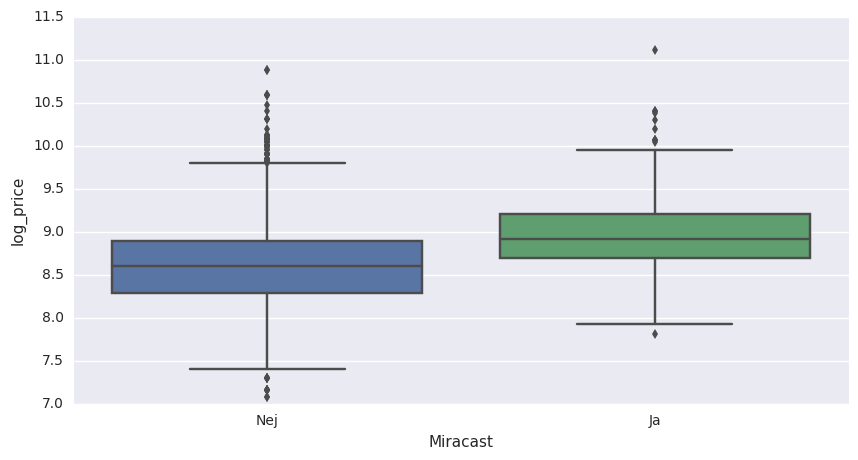

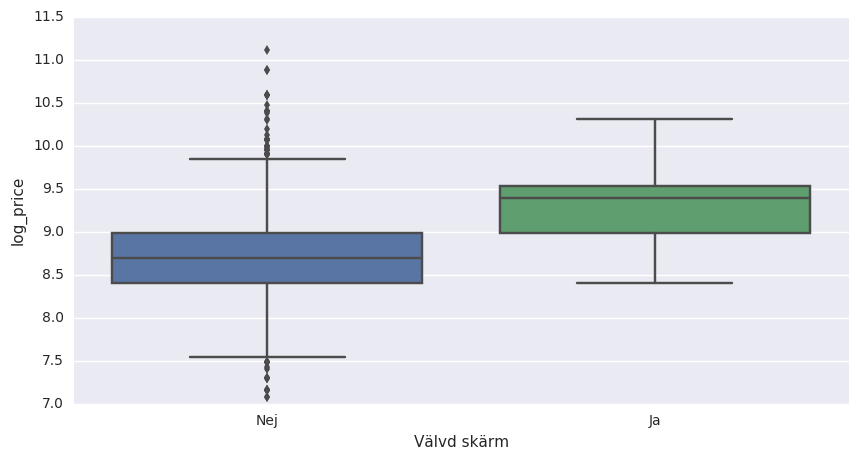

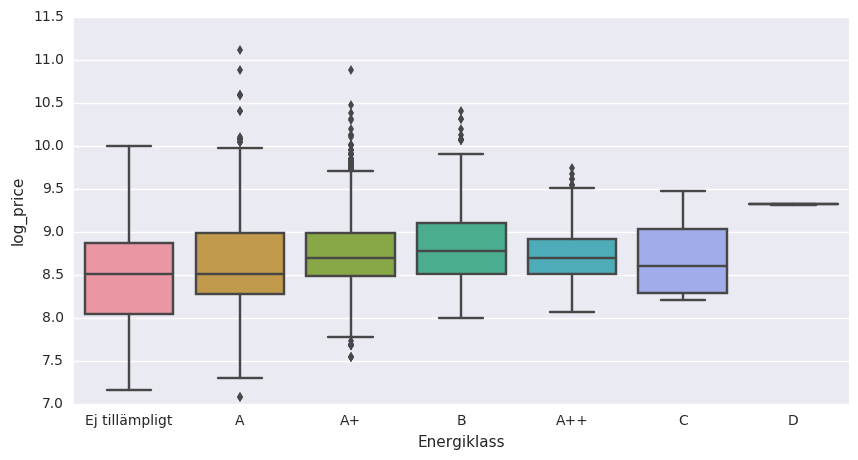

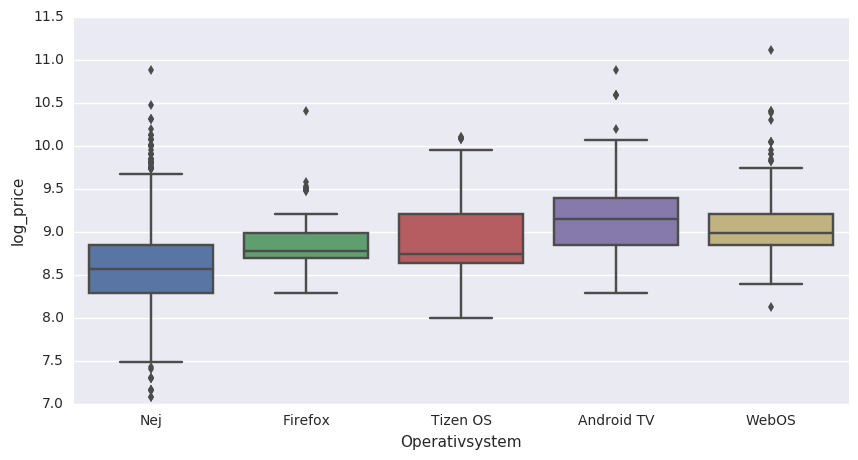

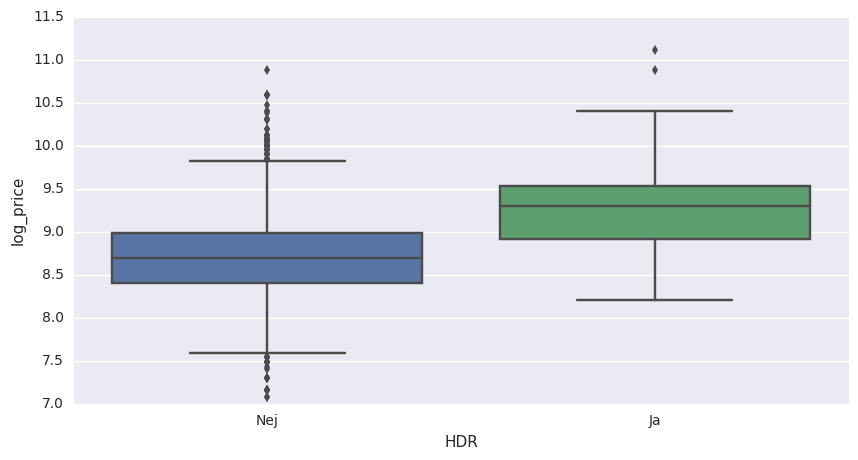

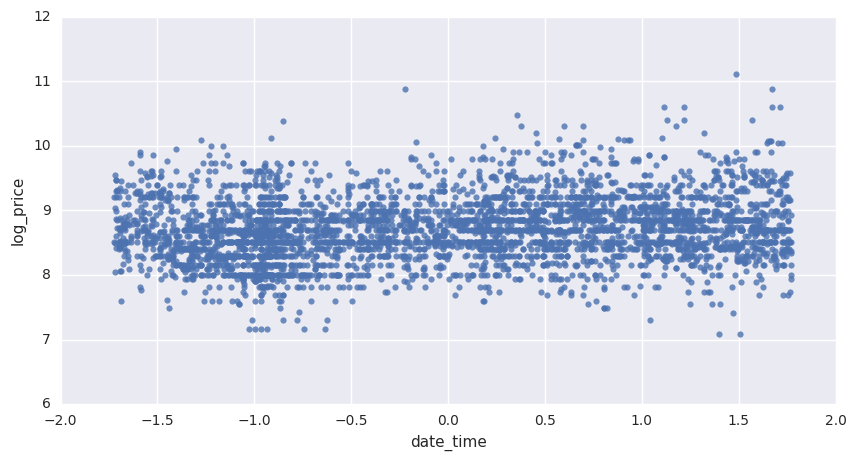

In [8]:
def reg_plot(x, y):
    return sns.regplot(x, y, fit_reg=False, scatter=True)
    
def bar_plot(x, y):
    return sns.boxplot(x, y)

temp = dropped_df.drop(['price', 'date', 'log_price'], axis=1)
plt.figure()
for col in temp:
    plt.figure(figsize=(10, 5))
    if np.issubdtype(dropped_df[col].dtype, np.number):
        fig = reg_plot(dropped_df[col], dropped_df['log_price'])
    else:
        fig = bar_plot(dropped_df[col], dropped_df['log_price'])
        if col == 'producer':
            plt.xticks(rotation=90)
    plt.show()
    time.sleep(0.5)

Going through the various plots, we can see that only a few of the features actually has a simple linear relationship with the price. The most obvious one being "Bildstorlek", though it has quite a lot of variance that increases with larger values.

The categorical features "Bildförhållande" and "HDMI in" only have one class in this part of the data set, which means that the other ones got thrown away when we dropped the NaN/null values. These should obviously not be part of the final feature set.

From the plots we have chosen a set features that seem to have a relationship with the price.

In [9]:
chosen_df = dropped_df[
    ['price', 'log_price', 'date', 'producer', 'Bildstorlek', 'Bildskärmsteknik', 
     'Digital utgång', 'Upplösningsformat', 'Komponent in', 'Timeshift',
     'DLNA.1', 'USB', 'Bluetooth', '3D-stöd', 'Ambilight', 
     'Internetanslutning', 'Miracast', 'Välvd skärm', 
     'Operativsystem', 'HDR', 'date_time']]

chosen_df['Operativsystem'].unique()

array(['Nej', 'Firefox', 'Tizen OS', 'Android TV', 'WebOS'], dtype=object)

A useful technique when we have categorical features where several classes have similar distributions is to group them into compound classes. A good example of this already in action is the 3D capability features. We have "3D-teknik" which tells us what 3D technology, if any, that the TV uses, but as we can see in the box plot, the technique in itself doesn't make much of a difference on the price. Here we might as well just use "3D-stöd", which simply says if the TV has 3D or not. This technique may be well suited for "Operativsystem", where we group OS/No OS and "producer", where we may group them into low, middle, high end producers.

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4078 entries, 0 to 5985
Data columns (total 23 columns):
price                 4078 non-null float64
log_price             4078 non-null float64
date                  4078 non-null object
producer              4078 non-null object
Bildstorlek           4078 non-null int64
Bildskärmsteknik      4078 non-null object
Digital utgång        4078 non-null object
Upplösningsformat     4078 non-null object
Komponent in          4078 non-null object
Timeshift             4078 non-null object
DLNA.1                4078 non-null object
USB                   4078 non-null object
Bluetooth             4078 non-null object
3D-stöd               4078 non-null object
Ambilight             4078 non-null object
Internetanslutning    4078 non-null object
Miracast              4078 non-null object
Välvd skärm           4078 non-null object
Operativsystem        4078 non-null object
HDR                   4078 non-null object
date_time             4078 non-n

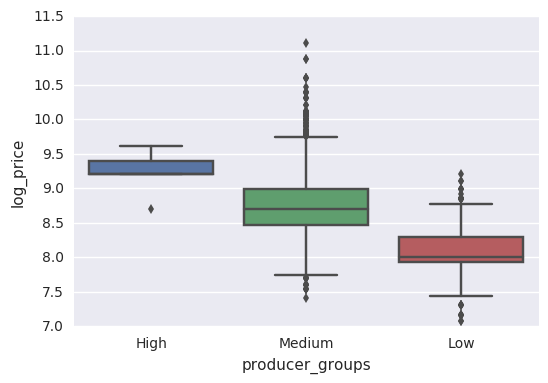

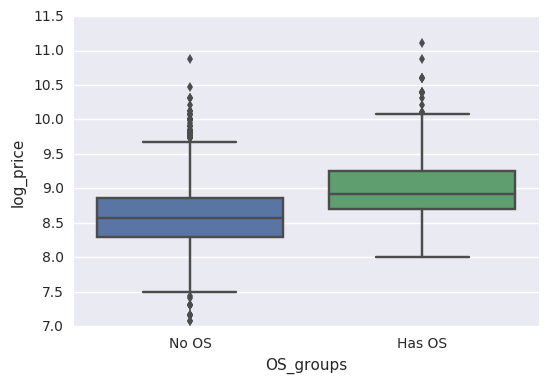

In [10]:
# x should be a series of categorical strings
# y should be the numerical target
# thresholds should hold the thresholds for grouping on y. Should be sorted in ascending and length = len(group_names) - 1
# group_names should hold the names for each threshold. 
#         Corresponding positions to thresholds except last one which will be used for all values above max(thresholds)
def group_by_threshold(x, y, thresholds, group_names):
    temp_x = x.copy()
    temp_y = y.copy()
    for threshold, group_name in zip(thresholds, group_names[:-1]):
        temp_x[temp_y < thresholds] = group_name
        temp_y[temp_y < thresholds] = np.NaN
    temp_x[temp_y > thresholds[-1]] = group_names[-1]
    return temp_x

# x should be a series of categorical strings
# class_groups should be an array of arrays, where each inner array corresponds to one value in group_names
# group_names should be an array of strings that hold the group names
def group_by_name(x, class_groups, group_names):
    temp_x = x.copy()
    for class_group, group_name in zip(class_groups, group_names):
        for class_name in class_group:
            temp_x[temp_x == class_name] = group_name
    return temp_x

chosen_df['producer_groups'] = group_by_name(chosen_df['producer'], 
                    [['Finlux Ltd', 'Toshiba Digital Media Sverige', 'Andersson', 
                         'Thomson Multimedia Scandinavia AB', 'Bosch AB', 'Turku TV Operation Ltd',
                         'JVC Svenska AB', 'TCL', 'Logik'],
                     ['Sony Sverige', 'Samsung Electronics Svenska AB', 'LG Electronics',
                      'Sharp Electronics (Svenska) AB', 'Grundig Svenska AB',
                      'Panasonic Svenska AB', 'Philips Konsumentelektronik AB',
                      'AOC International'],
                     ['Northern Star', 'Pioneer Scandinavia AB']], ['Low', 'Medium', 'High'])

sns.boxplot(chosen_df['producer_groups'], chosen_df['log_price'])

chosen_df['OS_groups'] = group_by_name(chosen_df['Operativsystem'], [['Nej'],['Tizen OS', 'Android TV', 'WebOS', 'Firefox']], ['No OS', 'Has OS'])
plt.figure()
sns.boxplot(chosen_df['OS_groups'], chosen_df['log_price'])
chosen_df.info()

Looking at the new box plots, we can see that the grouping seems to be working, and we have now cut away a lot of categorical variables.

Now that we've gone through some data analysis, feature selection and preprocessing, we can soon start fitting models to our data. But before we can do that, we have to transform all the text features into numerical values, as almost all ML algorithms require that. The most common way to do this is through one-hot encoding, which means that we split one column (feature) into new binary columns, where the number of new columns is equal the number of unique values in the original column. One row (data point) is allowed to have 1 (true) in only one of the new columns.

Each new column created from a categorical text feature was named after the convention "Column_name:Category_name".

In [11]:
final_df = chosen_df.drop(['price', 'producer', 'Operativsystem', 'date'], axis=1).copy()
for col in final_df:
    if col != "price" and col != 'date' and col != 'Bildstorlek' and col != 'log_price' and col != 'date_time': 
        encoded_categories = pd.get_dummies(final_df[col])
        for inner_col in encoded_categories:
            new_col_name = col + ":" + str(inner_col)
            encoded_categories = encoded_categories.rename(columns = {inner_col:new_col_name})
        final_df = final_df.drop([col], axis=1).join(encoded_categories)

In [12]:
corr=final_df.corr()["log_price"]
corr[np.argsort(corr, axis=0)[::-1]]

log_price                        1.000000
Bildstorlek                      0.819907
3D-stöd:Ja                       0.568246
Internetanslutning:Lan/Wlan      0.562292
DLNA.1:Ja                        0.544884
Upplösningsformat:Ultra HD       0.471621
producer_groups:Medium           0.374611
OS_groups:Has OS                 0.346386
Digital utgång:Optisk            0.310460
Välvd skärm:Ja                   0.279304
Miracast:Ja                      0.255471
HDR:Ja                           0.233551
Komponent in:Ja                  0.232937
Timeshift:Ja                     0.200205
Bluetooth:Ja                     0.186777
date_time                        0.182732
USB:Ja                           0.169401
Ambilight:Ja                     0.162170
Bildskärmsteknik:OLED            0.143268
Bildskärmsteknik:LED-LCD         0.067022
producer_groups:High             0.045770
Internetanslutning:Wlan         -0.002491
Digital utgång:Optisk/Koaxial   -0.010529
Bildskärmsteknik:Plasma         -0

Looking at the correlation between log_price and all the other features, we see that screen size, 3D capability, internet capability and screen resolution are most correlated with the price. We also see that the screen technology, Ambilight and USB don't correlate very much with the price. Something we could do if we do a new iteration of data wrangling after having trained our model is to remove the features with low correlation and train a new model on that data set.

After having checked the correlations between the features and the price, we will also check if there are any correlations between the top 10 features. The reason this is important is that some algorithms get better performance when we remove features that are highly correlated. An easy way to get an overview over the correlation is to draw a heatmap over the correlation matrix we get from .corr().

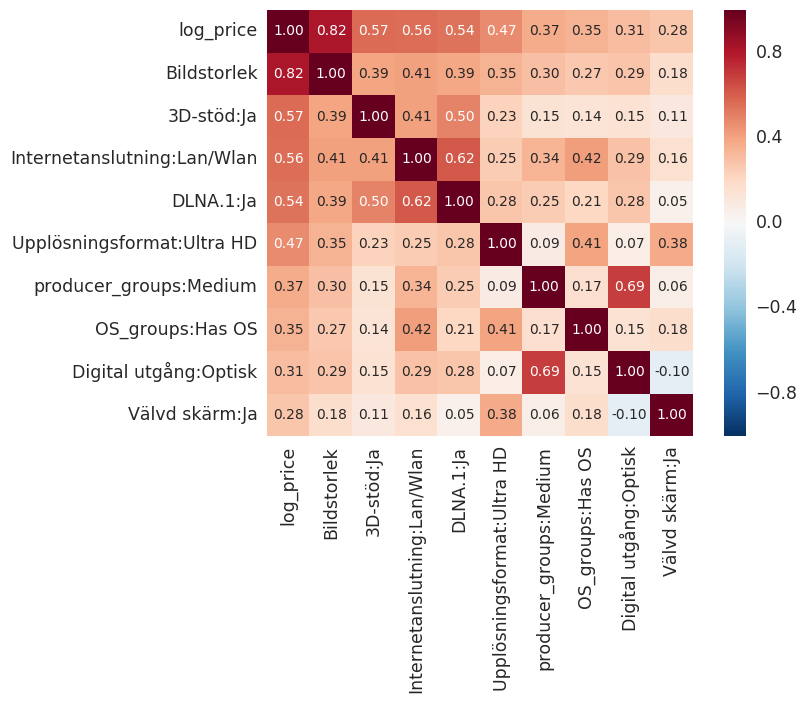

In [13]:
corrmat = final_df.corr()

#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'log_price')['log_price'].index
cm = np.corrcoef(np.absolute(final_df[cols]).values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Looking at the heatmap, we can see that internet with Lan/Wlan and DLNA.1 has a relatively high correlation, but it is not so high that we have to worry about it, though it may be a potential change for a new iteration of data wrangling. Surprisingly, the optical output and and medium producer group has an even higher correlation, though still not too high. It may be because of accident of our data set, but probably nothing to worry about now, though once again, may be a potential change for a new iteration.

## Training
Now we've finally reached the training part, which may be the easier and the harder part of a machine learning workflow, depending on the algorithm(s), amount of data and many other factors. In our case, it is mostly the easier part, though we could try to add other algorithms that may be more or less advanced. 

In [14]:
# Makes the algorithms give us the same results each time we run it
np.random.seed(12345)

# Split the data into a train set and a test set
X_train, X_test, y_train, y_test = train_test_split(final_df.drop('log_price', axis=1), final_df['log_price'], test_size=0.2)

# The actual training
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

That's it, now we've trained a simple Linear Regression model using the data that we've cleaned up and preprocessed.

## Model test
Now it's time to test our model on the test set to determine the performance of our model. Because we used a transformation on our price using the log function to make it more like a normal distribution, we have to do an inverse transform to actually get a price.

In [15]:
predict_test = lr.predict(X_test)

# Inverse transform of log is e^x, that is the exponential function
inverse_lambda = lambda x: math.exp(x)
inverse_transformer = np.vectorize(inverse_lambda)

transformed_predicted = inverse_transformer(predict_test)
y_test_transform = y_test.map(inverse_lambda)

There are several ways of validating a regression model. They can usually be grouped into numerical or graphical methods. In the case numerical methods, we've added the mean squared error (MSE) and the R^2 score. The MSE is just what the name suggests, you calculate the difference between each predicted value and the corresponding correct value, sum them up, and divide by the number of values. It is commonly used as a target value in training algorithms, though the actual value is not very informative when we want to analyse the model, but it can be used to compare different models, where the model with the lower score is "better". The R^2 score, sometimes aka variance score, is a number that in some sense tells us how well our model can predict the variance of our data. The R^2 score can vary between -1 and 1, where a higher value is better. 

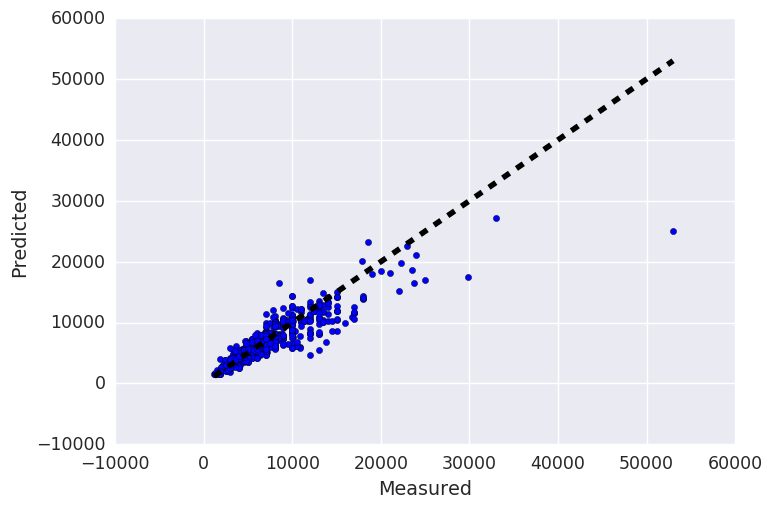

In [16]:
fig, ax = plt.subplots()
ax.scatter(y_test_transform, transformed_predicted)
ax.plot([y_test_transform.min(), y_test_transform.max()], [y_test_transform.min(), y_test_transform.max()], 'k--', lw=4)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
plt.show()

In [17]:
# The coefficients
print('Coefficients: \n', lr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((transformed_predicted - y_test_transform) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lr.score(X_test, y_test))

Coefficients: 
 [ 0.03425304 -0.05410419 -0.01948847 -0.11374662  0.36729542 -0.23406033
 -0.02557061  0.04897823 -0.01493222 -0.0084754  -0.07125479 -0.09401971
  0.1652745   0.01072669 -0.01072669 -0.00108352  0.00108352  0.04954229
 -0.04954229  0.00269032 -0.00269032 -0.00740471  0.00740471  0.08766356
 -0.08766356  0.07773343 -0.07773343 -0.03604041  0.05627656 -0.07052818
  0.05029203 -0.03431657  0.03431657  0.0655345  -0.0655345   0.00460117
 -0.00460117  0.1636113  -0.18314532  0.01953402  0.03524883 -0.03524883]
Mean squared error: 3908646.72
Variance score: 0.84


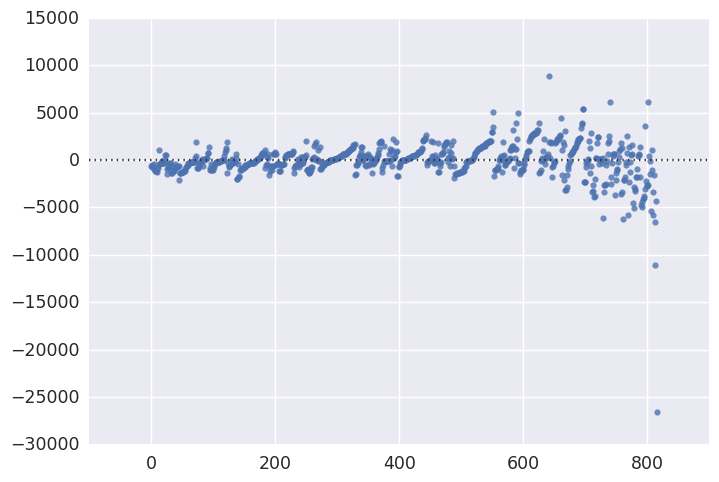

In [18]:
residuals = (transformed_predicted - y_test_transform)

pred_test_sorted, residuals_sorted = (np.asarray(list(t)) for t in zip(*sorted(zip(y_test, residuals))))

sns.residplot(np.arange(0, residuals_sorted.shape[0]), residuals_sorted)

In [19]:
DataFrame(np.absolute(residuals_sorted), columns=['residuals']).describe()

,residuals
count,816.000000
mean,1150.924326
std,1608.474587
min,0.484078
25%,311.753029
50%,697.725300
75%,1403.938496
max,28016.696249
